# **MA24M019**     **RAHUL** **K P**

#Comparing Support Vector Machines with Gaussian Kernels to Radial Basis Function Classifiers


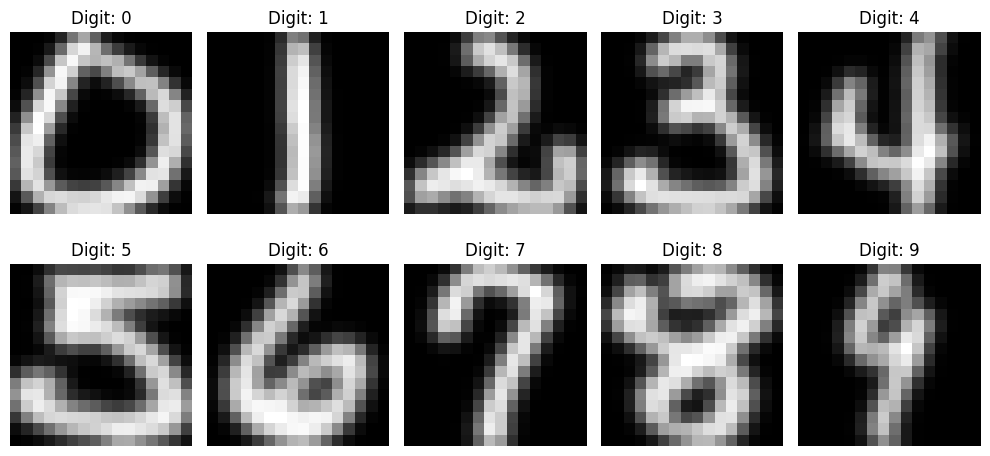

**Purpose:** Import necessary Python libraries for data manipulation, machine learning, image processing, and visualization.
- **Libraries:** `numpy`, `sklearn` (for datasets, clustering, SVM, logistic regression, preprocessing, model selection, and metrics), `matplotlib` for plotting, and `PIL` for image handling.

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from scipy.interpolate import interp1d
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np


In [ ]:
class AlphaFractal: # only for subintervals with equal size
    def __init__(self, scale_vector, b_func, f_func, interval, num_intervals, max_depth):
        self.scale_vector = scale_vector    # Define alpha  values as a class member
        self.b_func = b_func  # Define Base function as a class member
        self.f_func = f_func  # Define function  as a class member
        self.I = interval  # Define interval as a class member
        self.N = num_intervals  # Define the number of intervals as a class member
        self.max_depth = max_depth  # Define max_depth as a class member
        self.h = (self.I[1] - self.I[0]) / self.N  # Calculate partition width
        self.transformations = []     # for storing w_i (x,y)
        self.create_transformations()   # making w_i(x,y)

    def create_transformations(self):
        for i in range(self.N):
            alpha = self.scale_vector[i]

            # Define L_i function for current i and add it to transformations
            def L_i(x, i=i):  # Capture current i in the function
                return (x - self.I[0]) / self.N + self.I[0] + i * self.h

            def w(x, y, alpha=alpha, L_i=L_i):
                x_new = L_i(x)
                y_new = alpha * (y - self.b_func(x)) + self.f_func(x_new)
                return x_new, y_new

            self.transformations.append(w)
    def generate_points(self, x0, y0):
        current_points = [(x0, y0)]
        points_x, points_y = [x0], [y0]

        for depth in range(self.max_depth):
            new_points = []
            for (x, y) in current_points:
                for transform in self.transformations:
                    new_x, new_y = transform(x, y)
                    points_x.append(new_x)
                    points_y.append(new_y)
                    new_points.append((new_x, new_y))
            current_points = new_points

        return points_x, points_y

    def falpha(self):
        # Generate points
        x_vals, y_vals = self.generate_points(0.5, 0.5)

        # Sort the points by x for interpolation
        sorted_indices = np.argsort(x_vals)
        x_sorted = np.array(x_vals)[sorted_indices]
        y_sorted = np.array(y_vals)[sorted_indices]

        # Remove duplicate x values to avoid issues with interpolation
        unique_indices = np.unique(x_sorted, return_index=True)[1]
        x_unique = x_sorted[unique_indices]
        y_unique = y_sorted[unique_indices]

        # Interpolate the points to create a continuous function
        f = interp1d(x_unique, y_unique, kind='linear', fill_value="extrapolate")

        return f

def interpolate_f(f, u, v, i, j):
    """
    Creates a cubic polynomial that passes through:
    - Endpoints (u, f(u)) and (v, f(v))
    - Internal points (a, f(a)) and (b, f(b))

    Args:
        f (function): Original function
        u, v (float): Interval endpoints
        a, b (float): Internal points (u < a < b < v)

    Returns:
        function: Interpolating polynomial
    """
    # Define the four points
    x_points = [u, i, j, v]
    y_points = [f(x) for x in x_points]

    # Fit a cubic polynomial (degree 3)
    coefficients = np.polyfit(x_points, y_points, deg=3)
    interpolant = np.poly1d(coefficients)

    return interpolant

def frbf_kernel_matrix(X1, X2, gamma=0.1):
    """
    Computes RBF kernel matrix between two datasets
    :param X1: Array of shape (n_samples_1, n_features)
    :param X2: Array of shape (n_samples_2, n_features)
    :param gamma: Kernel width parameter
    :return: Kernel matrix of shape (n_samples_1, n_samples_2)
    """
    # Efficient squared Euclidean distance calculation
    norms_1 = np.sum(X1**2, axis=1)[:, np.newaxis]
    norms_2 = np.sum(X2**2, axis=1)[np.newaxis, :]
    distances = norms_1 + norms_2 - 2 * np.dot(X1, X2.T)
    return g( np.abs(distances)* gamma )

def rbf_kernel_matrix(X1, X2, gamma=0.1):
    """
    Computes RBF kernel matrix between two datasets
    :param X1: Array of shape (n_samples_1, n_features)
    :param X2: Array of shape (n_samples_2, n_features)
    :param gamma: Kernel width parameter
    :return: Kernel matrix of shape (n_samples_1, n_samples_2)
    """
    # Efficient squared Euclidean distance calculation
    norms_1 = np.sum(X1**2, axis=1)[:, np.newaxis]
    norms_2 = np.sum(X2**2, axis=1)[np.newaxis, :]
    distances = norms_1 + norms_2 - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * np.abs(distances))  # Absolute for numerical stability

Load the USPS dataset, convert data types, and split it into training and testing sets.
- **Process:**
  - Fetch the USPS dataset from OpenML.
  - Convert data to appropriate types (`float64` for features, `int64` for labels).
  - Split the dataset into 80% training and 20% testing sets.

In [ ]:
# Load the USPS dataset
usps = fetch_openml('usps', version=2)
X = usps.data.astype('float64').to_numpy()
y = usps.target.astype('int64').to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**RBF Network Implementation**
- **Purpose:** Implement an RBF network for digit recognition.
- **Process:**
  - Compute centroids and variances for each digit class using SVM support vectors.
  - Generate RBF features for training data.
  - Train a logistic regression classifier on these features.
  - Define a prediction function using RBF features.



In [ ]:
def KMeans_center(X_train, y_train, digit):
    """
    Computes RBF kernel parameters (centroids and variances) for a specific class

    Args:
        X_train: Full training data (n_samples, n_features)
        y_train: Training labels (n_samples,)
        digit: Target class to process

    Returns:
        centroids: Cluster centers from KMeans (n_kernels, n_features)
        variances: Per-cluster variances (n_kernels,)
    """
    # Create binary labels for current digit
    y_binary = (y_train == digit).astype(int)

    # Train SVM for one-vs-rest classification
    svm = SVC(kernel='rbf', random_state=42)
    svm.fit(X_train, y_binary)

    # Get number of kernels from support vectors count
    n_kernels = svm.n_support_[1]  # Positive class support vectors

    # Filter data for current digit
    X_digit = X_train[y_train == digit]

    # Cluster digit-specific data using KMeans
    kmeans = KMeans(n_clusters=n_kernels, n_init=10, random_state=42)
    kmeans.fit(X_digit)

    # Compute centroids and variances
    centroids = kmeans.cluster_centers_
    variances = [
        np.mean(np.sum((X_digit[kmeans.labels_ == i] - centroids[i])**2, axis=1))
        for i in range(n_kernels)
    ]

    return centroids, np.array(variances)

def svm_center(X_train, y_train, digit):
    svm = SVC(kernel='rbf', random_state=42)
    y_binary = (y_train == digit).astype(int)
    svm.fit(X_train, y_binary)

    # Use support vectors as centroids
    centroids = svm.support_vectors_
    n_kernels = len(centroids)

    # Compute variances for each centroid based on support vectors
    variances = []
    for i in range(n_kernels):
        cluster_points = X_train[y_train == digit]  # Points belonging to the current class
        variance = np.mean(np.sum((cluster_points - centroids[i])**2, axis=1))
        variances.append(variance)
    return centroids, np.array(variances)



def compute_rbf(X, centroids, variances):
    rbf_outputs = []
    for centroid, variance in zip(centroids, variances):
        # Apply Gaussian kernel formula: exp(-||x - c||^2 / (2 * variance))
        distances = np.linalg.norm(X - centroid, axis=1)**2
        rbf_output = np.exp(-distances / (2 * variance))
        rbf_outputs.append(rbf_output)
    return np.array(rbf_outputs).T


def compute_frbf(X, centroids, variances):
    rbf_outputs = []
    for centroid, variance in zip(centroids, variances):
        # Apply Gaussian kernel formula: exp(-||x - c||^2 / (2 * variance))
        distances = np.linalg.norm(X - centroid, axis=1)**2
        rbf_output = g(distances / (2 * variance))
        rbf_outputs.append(rbf_output)
    return np.array(rbf_outputs).T


def train_rbf_classifier(X_train, y_train, kernel, center):
    unique_classes = np.unique(y_train)
    centroids_per_class = {}
    variances_per_class = {}

    for digit in unique_classes:
        digit_key = int(digit)  # FIX 1: Convert digit to int
        centroids, variances = center(X_train, y_train, digit)

        # Store results with proper keys
        centroids_per_class[digit_key] = centroids  # FIX 2: Use converted key
        variances_per_class[digit_key] = variances  # FIX 2: Use converted key

    # Generate RBF features for training data
    rbf_features_train = []
    for digit in unique_classes:
        digit_key = int(digit)  # FIX 3: Consistent key type
        centroids = centroids_per_class[digit_key]
        variances = variances_per_class[digit_key]
        rbf_features_train.append(kernel(X_train, centroids, variances))

    rbf_features_train = np.hstack(rbf_features_train)
    final_classifier = LogisticRegression(max_iter=1000, random_state=42)
    final_classifier.fit(rbf_features_train, y_train)

    return final_classifier, centroids_per_class, variances_per_class, unique_classes

# Convert unique_classes to Python integers when predicting
def rbf_predict(X, final_classifier, centroids_per_class, variances_per_class, kernel, unique_classes):
    rbf_features = []
    for digit in map(int, unique_classes):  # Convert numpy ints to Python ints
        centroids = centroids_per_class[digit]
        variances = variances_per_class[digit]
        rbf_features.append(kernel(X, centroids, variances))
    rbf_features = np.hstack(rbf_features)
    return final_classifier.predict(rbf_features)
def first_five(X_test, y_pred):
  # Visualize some test samples with predictions
    X_test_np = X_test.to_numpy() if not isinstance(X_test, np.ndarray) else X_test

    fig, axes = plt.subplots(1, 5, figsize=(10, 3))
    for i, ax in enumerate(axes):
        ax.imshow(X_test_np[i].reshape(16, 16), cmap='gray')
        ax.set_title(f"Pred: {y_pred[i]-1}")
        ax.axis('off')
    plt.show()
def cm(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
# Define the interval and partition
u, v = 0, 2
I = [u, v]                                  # Interval for sine function
N = 5                                      # Number of intervals
max_depth = 9                               # Set max depth for fractal generation
# Define an array for alpha values, each corresponding to one transformation
alpha_array = [-0.03, 0.05, -0.05, -0.22, -0.14]    # Adjust values as needed
c, gamma = 0.1, 0.01


def f(x):
    return np.exp(-((x - c) ** 2))

# Base function b(x)
b = interpolate_f(f, u, v, (u+v)/3, (u+v)*2/3)

In [ ]:
# Initialize the AlphaFractal with the array of alpha values and transformations
alpha_fractal = AlphaFractal(scale_vector=alpha_array, b_func=b, f_func=f, interval=I, num_intervals=N, max_depth=max_depth)
g=alpha_fractal.falpha()

In [ ]:
model, center, varience, classes = train_rbf_classifier(X_train, y_train, compute_rbf, KMeans_center)
y_pred = rbf_predict(X_test, model, center, varience, compute_rbf, classes)

In [ ]:
W, C, V, U = train_rbf_classifier(X_train, y_train, compute_frbf, svm_center)

Training Accuracy: 97.15%
Test Accuracy: 95.32%


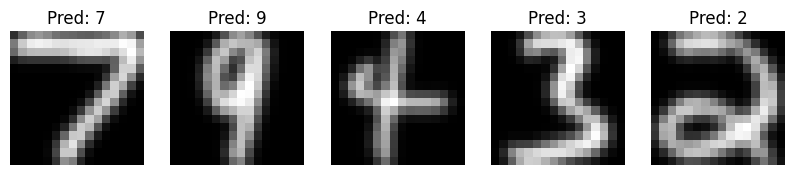

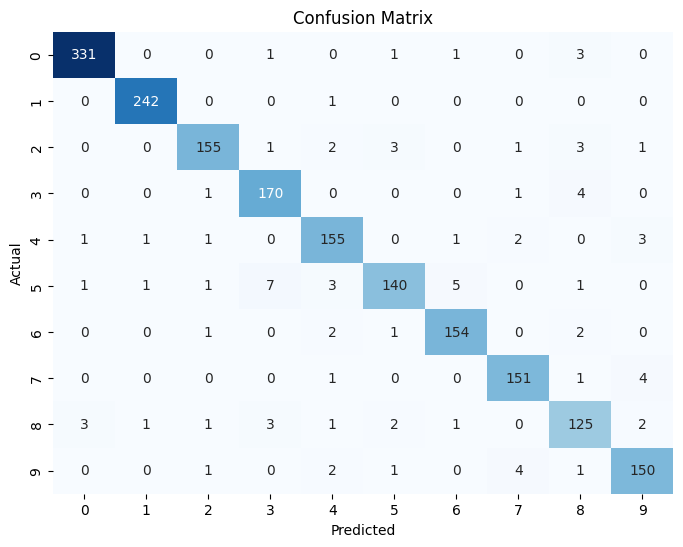

In [ ]:
# Evaluate accuracy using the predict function
y_pred = rbf_predict(X_test, W, C, V, compute_frbf, U)
y_pred_train = rbf_predict(X_train, W, C, V, compute_frbf, U)

train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

first_five(X_test, y_pred)
cm(y_test, y_pred)

In [ ]:
print("rbf network with kmeans")
# K-fold cross-validation setup [3]
kf = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Train and predict
    model, center, variance, classes = train_rbf_classifier(
        X_train_fold, y_train_fold, compute_rbf, KMeans_center
    )
    y_pred = rbf_predict(X_test_fold, model, center, variance, compute_rbf, classes)

    # Calculate metrics
    metrics['accuracy'].append(accuracy_score(y_test_fold, y_pred))
    metrics['precision'].append(precision_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))
    metrics['recall'].append(recall_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))
    metrics['f1'].append(f1_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))

# Print average metrics
print(f"Average Accuracy: {np.mean(metrics['accuracy']):.4f}")
print(f"Average Precision: {np.mean(metrics['precision']):.4f}")
print(f"Average Recall: {np.mean(metrics['recall']):.4f}")
print(f"Average F1-Score: {np.mean(metrics['f1']):.4f}")

rbf network with kmeans
Average Accuracy: 0.9469
Average Precision: 0.9487
Average Recall: 0.9469
Average F1-Score: 0.9470


In [ ]:
print("frbf network with kmeans")
# K-fold cross-validation setup [3]
kf = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Train and predict
    model, center, variance, classes = train_rbf_classifier(
        X_train_fold, y_train_fold, compute_frbf, KMeans_center
    )
    y_pred = rbf_predict(X_test_fold, model, center, variance, compute_frbf, classes)

    # Calculate metrics
    metrics['accuracy'].append(accuracy_score(y_test_fold, y_pred))
    metrics['precision'].append(precision_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))
    metrics['recall'].append(recall_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))
    metrics['f1'].append(f1_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))

# Print average metrics
print(f"Average Accuracy: {np.mean(metrics['accuracy']):.4f}")
print(f"Average Precision: {np.mean(metrics['precision']):.4f}")
print(f"Average Recall: {np.mean(metrics['recall']):.4f}")
print(f"Average F1-Score: {np.mean(metrics['f1']):.4f}")

frbf network with kmeans


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Average Accuracy: 0.9478
Average Precision: 0.9483
Average Recall: 0.9478
Average F1-Score: 0.9477


In [ ]:

# K-fold cross-validation setup [3]
print("hybrid rbf")
kf = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Train and predict
    model, center, variance, classes = train_rbf_classifier(
        X_train_fold, y_train_fold, compute_rbf, svm_center
    )
    y_pred = rbf_predict(X_test_fold, model, center, variance, compute_rbf, classes)

    # Calculate metrics
    metrics['accuracy'].append(accuracy_score(y_test_fold, y_pred))
    metrics['precision'].append(precision_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))
    metrics['recall'].append(recall_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))
    metrics['f1'].append(f1_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))

# Print average metrics
print(f"Average Accuracy: {np.mean(metrics['accuracy']):.4f}")
print(f"Average Precision: {np.mean(metrics['precision']):.4f}")
print(f"Average Recall: {np.mean(metrics['recall']):.4f}")
print(f"Average F1-Score: {np.mean(metrics['f1']):.4f}")

hybrid rbf
Average Accuracy: 0.9589
Average Precision: 0.9593
Average Recall: 0.9589
Average F1-Score: 0.9588


In [ ]:

# K-fold cross-validation setup [3]
print("hybrid frbf")
kf = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Train and predict
    model, center, variance, classes = train_rbf_classifier(
        X_train_fold, y_train_fold, compute_frbf, svm_center
    )
    y_pred = rbf_predict(X_test_fold, model, center, variance, compute_frbf, classes)

    # Calculate metrics
    metrics['accuracy'].append(accuracy_score(y_test_fold, y_pred))
    metrics['precision'].append(precision_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))
    metrics['recall'].append(recall_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))
    metrics['f1'].append(f1_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))

# Print average metrics
print(f"Average Accuracy: {np.mean(metrics['accuracy']):.4f}")
print(f"Average Precision: {np.mean(metrics['precision']):.4f}")
print(f"Average Recall: {np.mean(metrics['recall']):.4f}")
print(f"Average F1-Score: {np.mean(metrics['f1']):.4f}")

hybrid frbf
Average Accuracy: 0.9581
Average Precision: 0.9585
Average Recall: 0.9581
Average F1-Score: 0.9580


In [ ]:

# K-fold cross-validation setup [3]
print("SVM  rbf")
kf = KFold(n_splits=10, shuffle=True, random_state=3)
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Train and predict
    svm_model = SVC(kernel='rbf', random_state=42)
    svm_model.fit(X_train_fold, y_train_fold)

    # Make predictions on the test set
    y_pred = svm_model.predict(X_test_fold)


    # Calculate metrics
    metrics['accuracy'].append(accuracy_score(y_test_fold, y_pred))
    metrics['precision'].append(precision_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))
    metrics['recall'].append(recall_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))
    metrics['f1'].append(f1_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))

# Print average metrics
print(f"Average Accuracy: {np.mean(metrics['accuracy']):.4f}")
print(f"Average Precision: {np.mean(metrics['precision']):.4f}")
print(f"Average Recall: {np.mean(metrics['recall']):.4f}")
print(f"Average F1-Score: {np.mean(metrics['f1']):.4f}")

SVM  rbf
Average Accuracy: 0.9756
Average Precision: 0.9760
Average Recall: 0.9756
Average F1-Score: 0.9756


**SVM Model Training**
- **Purpose:** Train an SVM model, make predictions, and evaluate its performance.
- **Process:**
  - Initialize and train an SVM with an RBF kernel.
  - Predict labels for the test set.
  - Calculate and print the accuracy.
  - Visualize some test samples with their predicted labels.

In [ ]:

# Define the interval and partition
u, v = 0, 4.945
I = [u, v]                                  # Interval for sine function
N = 3                                      # Number of intervals
max_depth = 9                               # Set max depth for fractal generation
# Define an array for alpha values, each corresponding to one transformation
alpha_array = [ 0.05555556, -0.05555556, -0.5 ]    # Adjust values as needed
gamma = 0.01


def f(x):
    return np.exp(-x)

# Base function b(x)
b = interpolate_f(f, u, v, (u+v)/3, (u+v)*2/3)

# Initialize the AlphaFractal with the array of alpha values and transformations
alpha_fractal = AlphaFractal(scale_vector=alpha_array, b_func=b, f_func=f, interval=I, num_intervals=N, max_depth=max_depth)
g=alpha_fractal.falpha()

In [ ]:
# K-fold cross-validation setup [3]
print("SVM  frbf")
kf = KFold(n_splits=10, shuffle=True, random_state=3)
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]


    K_train = frbf_kernel_matrix(X_train_fold, X_train_fold, gamma)

    K_test = frbf_kernel_matrix(X_test_fold, X_train_fold, gamma)

    svm = SVC(kernel='precomputed')
    svm.fit(K_train, y_train_fold)
    y_pred = svm.predict(K_test)


    # Calculate metrics
    metrics['accuracy'].append(accuracy_score(y_test_fold, y_pred))
    metrics['precision'].append(precision_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))
    metrics['recall'].append(recall_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))
    metrics['f1'].append(f1_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))

# Print average metrics
print(f"Average Accuracy: {np.mean(metrics['accuracy']):.4f}")
print(f"Average Precision: {np.mean(metrics['precision']):.4f}")
print(f"Average Recall: {np.mean(metrics['recall']):.4f}")
print(f"Average F1-Score: {np.mean(metrics['f1']):.4f}")

SVM  frbf
Average Accuracy: 0.9753
Average Precision: 0.9757
Average Recall: 0.9753
Average F1-Score: 0.9753


In [ ]:
print("MLP with kmeans")
# K-fold cross-validation setup [3]
kf = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Train and predict
    mlp = MLPClassifier(hidden_layer_sizes=(100), max_iter=1500, alpha=1e-4,
                    solver='adam', verbose=False, random_state=42)
    mlp.fit(X_train_fold, y_train_fold)

    # Make predictions
    y_pred = mlp.predict(X_test_fold)


    # Calculate metrics
    metrics['accuracy'].append(accuracy_score(y_test_fold, y_pred))
    metrics['precision'].append(precision_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))
    metrics['recall'].append(recall_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))
    metrics['f1'].append(f1_score(y_test_fold, y_pred,
        average='weighted', zero_division=0))

# Print average metrics
print(f"Average Accuracy: {np.mean(metrics['accuracy']):.4f}")
print(f"Average Precision: {np.mean(metrics['precision']):.4f}")
print(f"Average Recall: {np.mean(metrics['recall']):.4f}")
print(f"Average F1-Score: {np.mean(metrics['f1']):.4f}")

MLP with kmeans
Average Accuracy: 0.9727
Average Precision: 0.9730
Average Recall: 0.9727
Average F1-Score: 0.9727


In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import itertools
import json
# Define the interval and partition
u, v = 0, 2
I = [u, v]                                  # Interval for sine function
N = 3                                     # Number of intervals
max_depth = 9                               # Set max depth for fractal generation

def optimize_parameters(X, y):
    # Define parameter search space
    num_points = 10  # Number of points between -0.5 and 0.5
    alpha_range = np.linspace(-0.5, 0.5, num_points)

    # Create a grid of values for all three dimensions
    alpha_options = np.array(np.meshgrid(alpha_range, alpha_range, alpha_range)).T.reshape(-1, 3)

    c_values = [0.01, 0.1, 1, 10]          # Regularization parameter
    gamma_values = [0.001, 0.01, 0.1, 1]    # RBF kernel parameter

    best_params = {
        'alpha_array': None,
        'c': None,
        'gamma': None,
        'accuracy': 0
    }

    # Grid search over all combinations
    for alpha, c, gamma in itertools.product(alpha_options, c_values, gamma_values):
        fold_accuracies = []
        def f(x):
            return np.exp(-((x - c) ** 2))
        # Initialize the AlphaFractal with the array of alpha values and transformations
        alpha_fractal = AlphaFractal(scale_vector=alpha, b_func=b, f_func=f, interval=I, num_intervals=N, max_depth=max_depth)
        g=alpha_fractal.falpha()
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Kernel matrix computation
            K_train = frbf_kernel_matrix(X_train, X_train, gamma)
            K_test = frbf_kernel_matrix(X_test, X_train, gamma)

            # SVM training and prediction
            svm = SVC(kernel='precomputed', C=c)
            svm.fit(K_train, y_train)
            y_pred = svm.predict(K_test)

            fold_accuracies.append(accuracy_score(y_test, y_pred))

        avg_accuracy = np.mean(fold_accuracies)

        if avg_accuracy > best_params['accuracy']:
            best_params = {
                'alpha_array': alpha.tolist(),
                'c': c,
                'gamma': gamma,
                'accuracy': avg_accuracy
            }

    return best_params

# Run optimization
best_params = optimize_parameters(X, y)

# Save best parameters
with open('best_params.json', 'w') as f:
    json.dump(best_params, f, indent=2)

print("Optimal parameters found:")
print(f"Alpha array: {best_params['alpha_array']}")
print(f"C: {best_params['c']}, Gamma: {best_params['gamma']}")
print(f"Validation Accuracy: {best_params['accuracy']:.4f}")


Training Accuracy: 98.82%
Test Accuracy: 97.42%


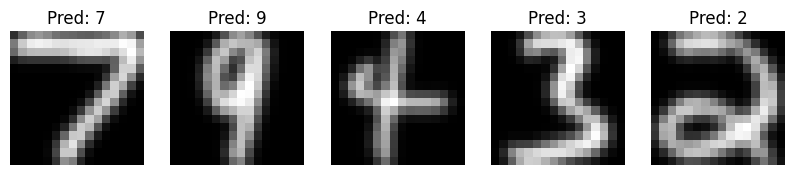

In [ ]:
# Initialize and train the SVM model
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)


y_pred_train = svm_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


# Visualize some test samples with predictions (convert X_test to NumPy array if needed)
X_test_np = X_test.to_numpy() if not isinstance(X_test, np.ndarray) else X_test

fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_test_np[i].reshape(16, 16), cmap='gray')
    ax.set_title(f"Pred: {y_pred[i]-1}")
    ax.axis('off')
plt.show()


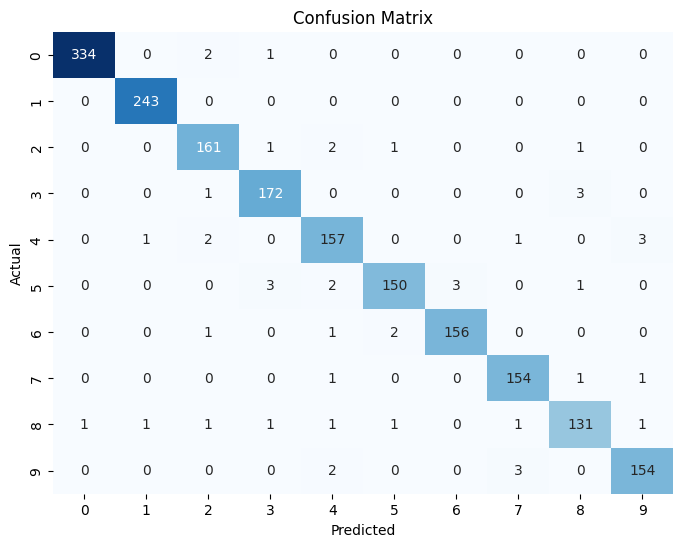

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


**MLP Classifier Training**
- **Purpose:** Train a Multi-Layer Perceptron (MLP) classifier, make predictions, and evaluate its performance.
- **Process:**
  - Set up an MLP with one hidden layer of 128 neurons.
  - Train the model on the training data.
  - Predict labels for the test set.
  - Calculate and print the accuracy.
  - Visualize some test samples with their predicted labels.

Training Accuracy: 99.96%
Test Accuracy: 97.04%


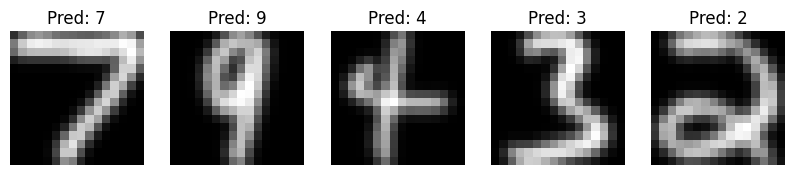

In [ ]:
# Initialize and train an MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100), max_iter=1500, alpha=1e-4,
                    solver='adam', verbose=False, random_state=42)
mlp.fit(X_train, y_train)

# Make predictions
y_pred = mlp.predict(X_test)


y_pred_train = mlp.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Visualize some test samples with predictions (convert X_test to NumPy array if needed)
X_test_np = X_test.to_numpy() if not isinstance(X_test, np.ndarray) else X_test

fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_test_np[i].reshape(16, 16), cmap='gray')
    ax.set_title(f"Pred: {y_pred[i]-1}")
    ax.axis('off')
plt.show()

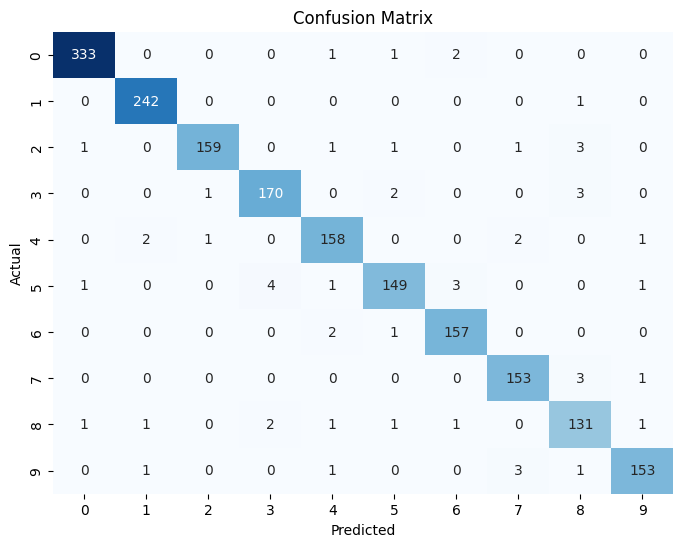

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


**Hybrid Model**
- **Purpose:** Combine svm centers and RBF-network for a hybrid model.
- **Process:**
  - Use the RBF features computed in the previous cell.
  - Train a logistic regression model on these features.
  - Define a prediction function for the hybrid model.

Training Accuracy: 96.63%
Test Accuracy: 95.32%


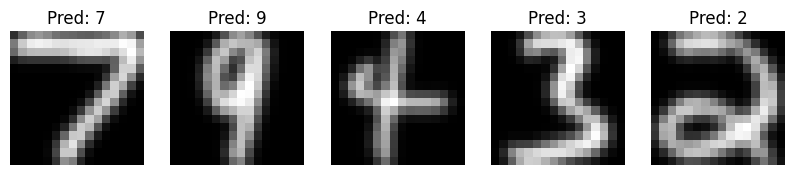

In [ ]:
# Step 1: Unique classes in the dataset
unique_classes = np.unique(y_train)

# Step 2: Initialize dictionaries to store centroids and variances for each digit class
centroids_per_class = {}
variances_per_class = {}

for digit in unique_classes:
    svm = SVC(kernel='rbf', random_state=42)
    y_binary = (y_train == digit).astype(int)
    svm.fit(X_train, y_binary)

    # Use support vectors as centroids
    centroids = svm.support_vectors_
    n_kernels = len(centroids)

    # Compute variances for each centroid based on support vectors
    variances = []
    for i in range(n_kernels):
        cluster_points = X_train[y_train == digit]  # Points belonging to the current class
        variance = np.mean(np.sum((cluster_points - centroids[i])**2, axis=1))
        variances.append(variance)

    centroids_per_class[digit] = centroids
    variances_per_class[digit] = variances

# Step 3: Function to compute RBF outputs for a given input and a class's centroids/variances
def compute_rbf_outputs(X, centroids, variances):
    rbf_outputs = []
    for centroid, variance in zip(centroids, variances):
        # Apply Gaussian kernel formula: exp(-||x - c||^2 / (2 * variance))
        distances = np.linalg.norm(X - centroid, axis=1)**2
        rbf_output = np.exp(-distances / (2 * variance))
        rbf_outputs.append(rbf_output)
    return np.array(rbf_outputs).T  # Transpose to get shape (n_samples, n_kernels)

# Step 4: Generate RBF features for training and testing data
rbf_features_train = []

for digit in unique_classes:
    centroids = centroids_per_class[digit]
    variances = variances_per_class[digit]

    # Compute RBF outputs for this class and append to the feature list
    rbf_features_train.append(compute_rbf_outputs(X_train, centroids, variances))

# Concatenate RBF features from all classes to form the final feature matrices
rbf_features_train = np.hstack(rbf_features_train)  # Shape: (n_samples_train, total_kernels)

# Step 5: Train a final classifier on the RBF-transformed features
final_classifier = LogisticRegression(max_iter=1000, random_state=42)
final_classifier.fit(rbf_features_train, y_train)

# Step 6: Define a predict function that takes the original input vector
def hybrid_predict(X):
    rbf_features = []
    for digit in unique_classes:
        centroids = centroids_per_class[digit]
        variances = variances_per_class[digit]
        rbf_features.append(compute_rbf_outputs(X, centroids, variances))
    rbf_features = np.hstack(rbf_features)  # Concatenate features from all classes
    return final_classifier.predict(rbf_features)

# Step 7: Predict on the test set and evaluate accuracy
y_pred = hybrid_predict(X_test)


y_pred_train = hybrid_predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Visualize some test samples with predictions
X_test_np = X_test.to_numpy() if not isinstance(X_test, np.ndarray) else X_test

fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_test_np[i].reshape(16, 16), cmap='gray')
    ax.set_title(f"Pred: {y_pred[i]-1}")
    ax.axis('off')
plt.show()


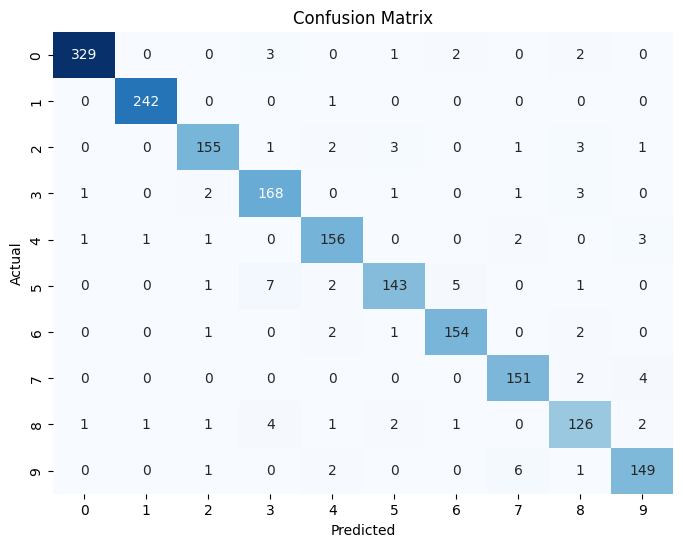

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Training Accuracy: 96.71%
Test Accuracy: 93.76%


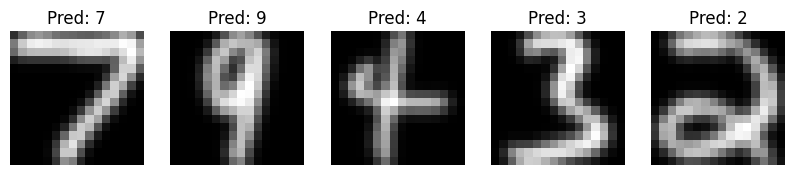

In [ ]:
# Unique classes in the dataset
unique_classes = np.unique(y)
kernels_per_class = {}

# Compute centroids and variances for each digit class
centroids_per_class = {}
variances_per_class = {}

for digit in unique_classes:
    # Train SVM for the current digit (one-vs-rest)
    svm = SVC(kernel='rbf', random_state=42)
    y_binary = (y_train == digit).astype(int)
    svm.fit(X_train, y_binary)

    # Number of support vectors determines the number of Gaussian kernels
    n_kernels = svm.n_support_[1]  # Number of support vectors for the positive class

    # Use KMeans to compute centroids and variances for RBF kernels
    kmeans = KMeans(n_clusters=n_kernels, n_init=10, random_state=42)
    X_digit = X_train[y_train == digit]
    kmeans.fit(X_digit)
    centroids = kmeans.cluster_centers_

    # Compute variances for each cluster
    variances = []
    for i in range(n_kernels):
        cluster_points = X_digit[kmeans.labels_ == i]
        variance = np.mean(np.sum((cluster_points - centroids[i])**2, axis=1))
        variances.append(variance)

    centroids_per_class[digit] = centroids
    variances_per_class[digit] = variances

# Function to compute RBF outputs for a given input and a class's centroids/variances
def compute_rbf_outputs(X, centroids, variances):
    rbf_outputs = []
    for centroid, variance in zip(centroids, variances):
        # Apply Gaussian kernel formula: exp(-||x - c||^2 / (2 * variance))
        distances = np.linalg.norm(X - centroid, axis=1)**2
        rbf_output = np.exp(-distances / (2 * variance))
        rbf_outputs.append(rbf_output)
    return np.array(rbf_outputs).T  # Transpose to get shape (n_samples, n_kernels)

# Generate RBF features for training data
rbf_features_train = []
for digit in unique_classes:
    centroids = centroids_per_class[digit]
    variances = variances_per_class[digit]

    # Compute RBF outputs for this class and append to the feature list
    rbf_features_train.append(compute_rbf_outputs(X_train, centroids, variances))

# Concatenate RBF features from all classes to form the final feature matrices
rbf_features_train = np.hstack(rbf_features_train)  # Shape: (n_samples_train, total_kernels)

# Train a final classifier on the RBF-transformed features
final_classifier = LogisticRegression(max_iter=1000, random_state=42)
final_classifier.fit(rbf_features_train, y_train)

# Define a predict function that takes the original input vector
def rbf_predict(X):
    rbf_features = []
    for digit in unique_classes:
        centroids = centroids_per_class[digit]
        variances = variances_per_class[digit]
        rbf_features.append(compute_rbf_outputs(X, centroids, variances))
    rbf_features = np.hstack(rbf_features)
    return final_classifier.predict(rbf_features)

# Evaluate accuracy using the predict function
y_pred = rbf_predict(X_test)
y_pred_train = rbf_predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Visualize some test samples with predictions
X_test_np = X_test.to_numpy() if not isinstance(X_test, np.ndarray) else X_test

fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_test_np[i].reshape(16, 16), cmap='gray')
    ax.set_title(f"Pred: {y_pred[i]-1}")
    ax.axis('off')
plt.show()


**Prediction on New Image**
- **Purpose:** Demonstrate how to use trained models to predict the digit in a new image.
- **Process:**
  - Preprocess a new image using the `resize_for_usps` function.
  - Display the preprocessed image.
  - Use each trained model (SVM, MLP, RBF, Hybrid) to predict the digit and print the results.

In [ ]:
def resize_for_usps(image_path):
    """
    Resize an image to 16x16 pixels, invert colors, and normalize pixel values for USPS dataset.
    """
    # Open the image and convert to grayscale
    img = Image.open(image_path).convert('L')  # 'L' mode is grayscale

    # Resize the image to 16x16 pixels
    img = img.resize((16, 16), Image.Resampling.LANCZOS)  # Use LANCZOS resampling for high-quality resizing

    # Invert the image (USPS has black digits on white background)
    img = Image.eval(img, lambda x: 255 - x)  # Invert colors

    # Convert the image to a NumPy array
    img_array = np.array(img)

    # Normalize pixel values to the range [-1, 1]
    img_array = img_array / 128.0 - 1.0

    return img_array

**Image Preprocessing Function**
- **Purpose:** Define a function to preprocess images for prediction.
- **Process:**
  - Open an image, convert to grayscale, resize to 16x16 pixels, invert colors, and normalize pixel values to fit the USPS dataset format.

In [ ]:
# Path to your image
image_path = "five.png"

# Preprocess the image
resized_image = resize_for_usps(image_path)

# Display the resized image
plt.imshow(resized_image, cmap='gray')
plt.title("Resized Image (16x16)")
plt.show()

# Prepare the image for prediction (flatten and add batch dimension)
input_data = resized_image.flatten().reshape(1, -1)  # Shape: (1, 256)


imagemlp = mlp.predict(input_data)  # Predict using your trained model
print("Predicted MLP Label:", imagemlp[0]-1)
imagesvm = svm_model.predict(input_data)
print("Predicted SVM Label:", imagesvm[0]-1)
imagerfb = rbf_predict(input_data)
print("Predicted RBF Label:", imagerfb[0]-1)
imagehb = hybrid_predict(input_data)
print("Predicted Hybrid Label:", imagehb[0]-1)

## Comparison of Model Performance

| Model       | Accuracy (%) | Notes                                                                 |
|-------------|--------------|-----------------------------------------------------------------------|
| SVM         | 97.42        | High accuracy, good for non-linear classification with RBF kernel.    |
| MLP         | 96.67        | Neural network approach, slightly less accurate than SVM but versatile.|
| Hybrid | 95.38        |  Combine svm centers and RBF-network for a hybrid model.           |
| RBF Network      | 93.76        | Combines RBF features with logistic regression, slightly lower accuracy due to complexity. |

This table summarizes the performance of each model on the test set, providing insights into their effectiveness for digit recognition on the USPS dataset.